## Imports

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV, GroupShuffleSplit, StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier

## Set Paths

In [2]:
DATA_PATH = 'training.csv'
UNLABELED_PATH = 'unlabeled.csv'

## Load and view training data

In [3]:
data = pd.read_csv(DATA_PATH)

print(data.shape)
data.head()

(2471, 16)


,participant_id,latitude,longitude,heart_rate,heart_rate_resting,heart_rate_variability,stand_time,step_count,walking_distance,temperature,relative_humidity,heat_index,dew_point,day_of_week,hour_of_day,general_location
0,malta01,1.303680,103.773538,NaN,NaN,NaN,NaN,NaN,NaN,29.298993,69.077737,34.555714,22.836399,3,17,0
1,malta01,1.299501,103.775276,NaN,NaN,NaN,NaN,NaN,NaN,29.298993,69.077737,34.555714,22.836399,3,18,0
2,malta01,1.305428,103.789796,79.0,NaN,NaN,NaN,NaN,NaN,29.298993,69.077737,34.555714,22.836399,3,18,0
3,malta01,1.306101,103.791138,NaN,NaN,NaN,NaN,NaN,NaN,29.298993,69.077737,34.555714,22.836399,3,18,0
4,malta01,1.306032,103.791090,NaN,NaN,NaN,NaN,NaN,NaN,29.298993,69.077737,34.555714,22.836399,3,19,0


In [4]:
unlabeled_data = pd.read_csv(UNLABELED_PATH)

print(unlabeled_data.shape)
unlabeled_data.head()

(72472, 15)


,participant_id,latitude,longitude,heart_rate,heart_rate_resting,heart_rate_variability,stand_time,step_count,walking_distance,temperature,relative_humidity,heat_index,dew_point,day_of_week,hour_of_day
0,malta01,1.303622,103.774365,79.0,NaN,NaN,NaN,18.0,NaN,29.298993,69.077737,34.555714,22.836399,3,18
1,malta01,1.295121,103.784422,NaN,NaN,NaN,NaN,35.0,NaN,29.298993,69.077737,34.555714,22.836399,3,18
2,malta01,1.303541,103.787420,NaN,NaN,NaN,NaN,NaN,NaN,29.298993,69.077737,34.555714,22.836399,3,18
3,malta01,1.304956,103.789142,NaN,NaN,NaN,60.0,NaN,NaN,29.298993,69.077737,34.555714,22.836399,3,18
4,malta01,1.306695,103.791192,113.0,NaN,NaN,NaN,NaN,NaN,29.298993,69.077737,34.555714,22.836399,3,18


## Split Train+Validation and Test set

In [5]:
# Assuming your DataFrame is named df
groups = data['participant_id']

# Initialize the splitter (e.g., 80% training, 20% test)
splitter = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)

# Split the data into train and test sets
train_idx, test_idx = next(splitter.split(data, groups=groups))
train_df = data.iloc[train_idx]
test_df = data.iloc[test_idx]

# Prepare training data and test data
X_train = train_df.drop(columns=['general_location', 'participant_id'])
y_train = train_df['general_location']
groups = train_df['participant_id']

X_test = test_df.drop(columns=['general_location', 'participant_id'])
y_test = test_df['general_location']

print("Training and test data prepared.")
print("X_train shape:", X_train.shape, "X_test shape:", X_test.shape)

Training and test data prepared.
X_train shape: (1879, 14) X_test shape: (592, 14)


In [6]:
# check unique values of participant id in train and test
print(train_df['participant_id'].nunique())
print(test_df['participant_id'].nunique())

17
5


- 17 participants are used in the training data
- 5 participants in the test data

In [7]:
# Initialize list to store performance metrics for each model
results = []

### Baseline 1: Predict mode only

In [8]:
# Get the most frequent label in y_train
mode_value = y_train.mode()[0]  

# Predict the mode for all instances
y_pred_mode = np.full(shape=y_test.shape, fill_value=mode_value)  

# Evaluate performance
f1_mode = f1_score(y_test, y_pred_mode)
precision_mode = precision_score(y_test, y_pred_mode)
recall_mode = recall_score(y_test, y_pred_mode)

# Store results and print metrics
results.append({'Model': 'Baseline - Mode Only', 'F1': f1_mode, 'Precision': precision_mode, 'Recall': recall_mode})
print("Baseline 1 (Mode Only) metrics:")
print("F1:", round(f1_mode, 3), "Precision:", round(precision_mode, 3), "Recall:", round(recall_mode, 3))

Baseline 1 (Mode Only) metrics:
F1: 0.673 Precision: 0.507 Recall: 1.0


### Baseline 2: Using only GPS coordinates

In [9]:
# Using only lat and lon features
features_latlon = ['latitude', 'longitude']
X_train_latlon = train_df[features_latlon]
X_test_latlon = test_df[features_latlon]

In [10]:
# Initialise baseline model
baseline_model_latlon = CatBoostClassifier(loss_function='Logloss', verbose=0, random_seed=42)

# Train the model
baseline_model_latlon.fit(X_train_latlon, y_train)  

# Predict on test set
y_pred_latlon = baseline_model_latlon.predict(X_test_latlon)  

# Evaluate performance
f1_latlon = f1_score(y_test, y_pred_latlon)
precision_latlon = precision_score(y_test, y_pred_latlon)
recall_latlon = recall_score(y_test, y_pred_latlon)

# Store results and print metrics
results.append({'Model': 'Baseline - Lat & Lon Only', 'F1': f1_latlon, 'Precision': precision_latlon, 'Recall': recall_latlon})
print("\nBaseline 2 (Lat & Lon Only) metrics:")
print("F1:", round(f1_latlon, 3), "Precision:", round(precision_latlon, 3), "Recall:", round(recall_latlon, 3))


Baseline 2 (Lat & Lon Only) metrics:
F1: 0.632 Precision: 0.498 Recall: 0.863


### Baseline 3: All features with default CatBoost parameters

In [11]:
# Train model using all features with default parameters
baseline_model_all = CatBoostClassifier(loss_function='Logloss', verbose=0, random_seed=42)

# Train the model
baseline_model_all.fit(X_train, y_train)  

# Predict on test set
y_pred_all = baseline_model_all.predict(X_test)  

# Evaluate performance
f1_all = f1_score(y_test, y_pred_all)
precision_all = precision_score(y_test, y_pred_all)
recall_all = recall_score(y_test, y_pred_all)

# Store results and print metrics
results.append({'Model': 'Baseline - All Features Default', 'F1': f1_all, 'Precision': precision_all, 'Recall': recall_all})
print("\nBaseline 3 (All Features Default) metrics:")
print("F1:", round(f1_all, 3), "Precision:", round(precision_all, 3), "Recall:", round(recall_all, 3))


Baseline 3 (All Features Default) metrics:
F1: 0.687 Precision: 0.586 Recall: 0.83


### Baseline 4: Nested CV Tuning without using group structure

Catboost Parameters Documentation
- https://catboost.ai/docs/en/concepts/parameter-tuning

These 3 are the most important
1. Learning Rate
2. Tree Depth
3. Number of Trees

In [12]:
# Define parameter grid for CatBoost
param_grid = {
    'learning_rate': [0.005, 0.01, 0.1, 0.2],  
    'depth': [4, 5, 6, 7],
    'iterations': [100, 200, 300, 500] 
}
print("Parameter grid:", param_grid)

Parameter grid: {'learning_rate': [0.005, 0.01, 0.1, 0.2], 'depth': [4, 5, 6, 7], 'iterations': [100, 200, 300, 500]}


In [13]:
# Setup standard StratifiedKFold (without grouping)
standard_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("StratifiedKFold created with 5 splits (no groups).")

# Initialize CatBoost model
cat_model = CatBoostClassifier(loss_function='Logloss', verbose=0, random_seed=42)

# Initialize GridSearchCV
grid_search_no_group = GridSearchCV(estimator=cat_model,
                                    param_grid=param_grid,
                                    scoring='f1',
                                    cv=standard_cv,
                                    n_jobs=-1)
print("Starting GridSearchCV without group constraint...")

# Fit the model
grid_search_no_group.fit(X_train, y_train)
print("GridSearchCV (No Group) complete.")
print("Best parameters (No Group):", grid_search_no_group.best_params_)
print("Best CV F1 score (No Group):", grid_search_no_group.best_score_)

StratifiedKFold created with 5 splits (no groups).
Starting GridSearchCV without group constraint...
GridSearchCV (No Group) complete.
Best parameters (No Group): {'depth': 7, 'iterations': 300, 'learning_rate': 0.1}
Best CV F1 score (No Group): 0.7893012420700529


In [14]:
# Train final model on full training data using best parameters (No Group)
final_model_no_group = CatBoostClassifier(
    **grid_search_no_group.best_params_,
    loss_function='Logloss',
    verbose=0,
    random_seed=42
)
final_model_no_group.fit(X_train, y_train)
print("Final model (No Group CV) trained on full training data.")

Final model (No Group CV) trained on full training data.


In [15]:
# Evaluate final model (No Group CV) on test set
y_pred_no_group = final_model_no_group.predict(X_test)
f1_no_group = f1_score(y_test, y_pred_no_group)
precision_no_group = precision_score(y_test, y_pred_no_group)
recall_no_group = recall_score(y_test, y_pred_no_group)
results.append({'Model': 'Baesline: Nested CV Tuning (No Group)', 'F1': f1_no_group, 'Precision': precision_no_group, 'Recall': recall_no_group})
print("\nNested CV Tuning (No Group) model metrics on test set:")
print("F1:", f1_no_group, "Precision:", precision_no_group, "Recall:", recall_no_group)


Nested CV Tuning (No Group) model metrics on test set:
F1: 0.675 Precision: 0.5785714285714286 Recall: 0.81


### Final Model: Stratified GroupKFold CV with Hyperparamter Tuning

In [16]:
# Setup StratifiedGroupKFold for 5-fold CV (respects participant_id groups)
group_cv = StratifiedGroupKFold(n_splits=5)
print("StratifiedGroupKFold created with 5 splits (respects participant_id).")

# Grid Search with inner CV
grid_search = GridSearchCV(estimator=cat_model,
                           param_grid=param_grid,
                           scoring='f1',
                           cv=group_cv,
                           n_jobs=-1)
print("Starting GridSearchCV with group-aware CV...")

# Fit the model
grid_search.fit(X_train, y_train, groups=groups)
print("GridSearchCV (Group) complete.")
print("Best parameters (Group):", grid_search.best_params_)
print("Best CV F1 score (Group):", round(grid_search.best_score_,3))

StratifiedGroupKFold created with 5 splits (respects participant_id).
Starting GridSearchCV with group-aware CV...
GridSearchCV (Group) complete.
Best parameters (Group): {'depth': 5, 'iterations': 300, 'learning_rate': 0.01}
Best CV F1 score (Group): 0.714


### Train final model 

1. Using best parameters from tuning
2. On full training set

In [17]:
# Train final model on full training data using best parameters (Group CV)
final_model = CatBoostClassifier(
    **grid_search.best_params_,
    loss_function='Logloss',
    verbose=0,
    random_seed=42
)
final_model.fit(X_train, y_train)
print("Final model (Group CV) trained on full training data.")

Final model (Group CV) trained on full training data.


### Evaluate final model on test set

In [18]:
# Evaluate final model (Group CV) on test set
y_pred_final = final_model.predict(X_test)
f1_final = f1_score(y_test, y_pred_final)
precision_final = precision_score(y_test, y_pred_final)
recall_final = recall_score(y_test, y_pred_final)
results.append({'Model': 'Nested CV Tuning (Group)', 'F1': f1_final, 'Precision': precision_final, 'Recall': recall_final})
print("\nNested CV Tuning (Group) model metrics on test set:")
print("F1:", round(f1_final,3), "Precision:", round(precision_final,3), "Recall:", round(recall_final,3))



Nested CV Tuning (Group) model metrics on test set:
F1: 0.715 Precision: 0.685 Recall: 0.747


### Compare performance metrics across models

In [19]:
# Compare performance metrics across models
results_df = pd.DataFrame(results)

# Round F1, Precision, and Recall to 3 decimal places
results_df[['F1', 'Precision', 'Recall']] = results_df[['F1', 'Precision', 'Recall']].round(3)

print("\nComparison of Model Performance on Test Set:")
results_df


Comparison of Model Performance on Test Set:


,Model,F1,Precision,Recall
0,Baseline - Mode Only,0.673,0.507,1.000
1,Baseline - Lat & Lon Only,0.632,0.498,0.863
2,Baseline - All Features Default,0.687,0.586,0.830
3,Baesline: Nested CV Tuning (No Group),0.675,0.579,0.810
4,Nested CV Tuning (Group),0.715,0.685,0.747


F1 Score comparison plot


/var/folders/25/96v60r2x2n1fr2b37qmwy46r0000gn/T/ipykernel_60771/2539576724.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='F1', y='Model', data=results_df, palette=custom_palette, edgecolor='black', linewidth=0.5)


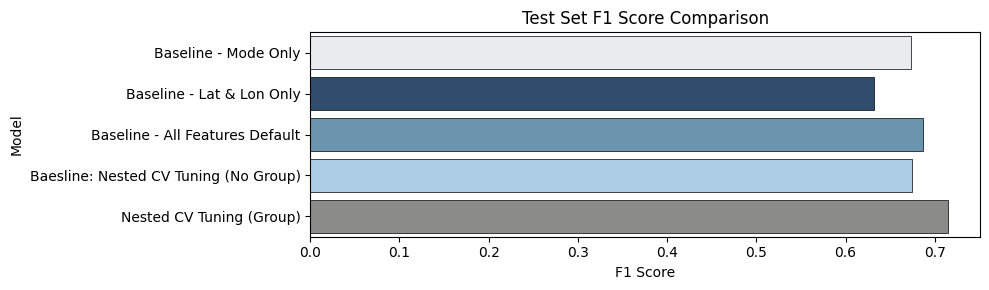

In [26]:
# Define colors
custom_palette = ['#e7ecef', '#274c77', '#6096ba', '#a3cef1', '#8b8c89']

# Plot horizontal bar chart of F1 scores for comparison
print("F1 Score comparison plot")
plt.figure(figsize=(10, 3))
sns.barplot(x='F1', y='Model', data=results_df, palette=custom_palette, edgecolor='black', linewidth=0.5)
plt.title("Test Set F1 Score Comparison")
plt.xlabel("F1 Score")
plt.ylabel("Model")
plt.tight_layout()
plt.show()

### Calculate Permutation Importance

In [21]:
# Permutation Importance on final (Group CV) model
print("\nComputing permutation importance for final (Group CV) model...")
perm_result = permutation_importance(final_model, X_test, y_test, scoring='f1', n_repeats=3, random_state=42)
importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance': perm_result.importances_mean
}).sort_values(by='importance', ascending=False)

print("Permutation importance computed.")
importance_df


Computing permutation importance for final (Group CV) model...
Permutation importance computed.


,feature,importance
1,longitude,0.051975
2,heart_rate,0.034764
7,walking_distance,0.031830
5,stand_time,0.024824
9,relative_humidity,0.010106
10,heat_index,0.010089
6,step_count,0.009176
11,dew_point,0.007001
0,latitude,0.005160
4,heart_rate_variability,0.005007


### Plot Permutation Importance

In [22]:
# Map each feature to its group
def get_feature_group(feature):
    if feature in ['longitude', 'latitude', 'day_of_week', 'hour_of_day']:
        return 'GPS Default'
    elif feature in ['heart_rate', 'walking_distance', 'stand_time', 'step_count', 'heart_rate_variability', 'heart_rate_resting']:
        return 'Physiological'
    elif feature in ['heat_index', 'dew_point', 'relative_humidity', 'temperature']:
        return 'Kestrel'
    else:
        return 'Other'

# Create a new column in importance_df for the feature group
importance_df['group'] = importance_df['feature'].apply(get_feature_group)

# Define the color mapping
group_colors = {
    'GPS Default': '#274c77',    
    'Physiological': '#6096ba',    
    'Kestrel': '#a3cef1',          
    'Other': '#8b8c89'         
}

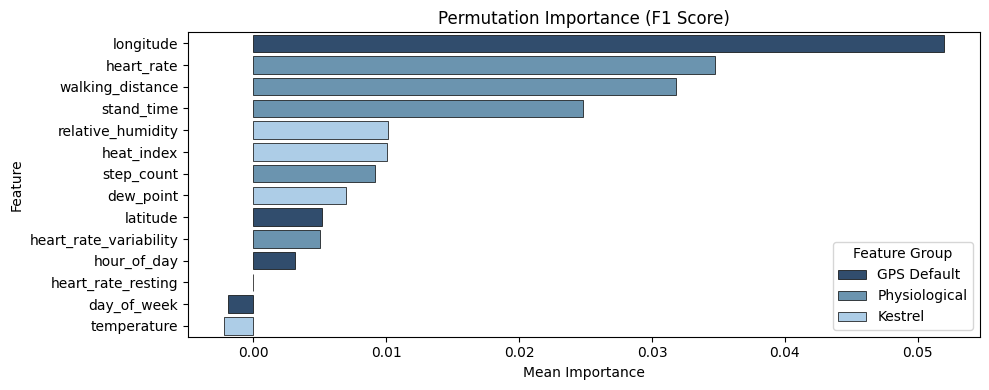

Permutation importance plot displayed.


In [28]:
# Create the horizontal bar plot 
plt.figure(figsize=(10, 4))
ax = sns.barplot(
    x='importance',
    y='feature',
    data=importance_df,
    hue='group',            
    palette=group_colors,
    dodge=False,            
    edgecolor='black',
    linewidth=0.5
)
plt.title('Permutation Importance (F1 Score)')
plt.xlabel('Mean Importance')
plt.ylabel('Feature')
plt.legend(title="Feature Group")
plt.tight_layout()
plt.show()
print("Permutation importance plot displayed.")

### Predict on unlabeled location data.

1. Use trained model to predict
2. Save results

In [24]:
# Drop 'participant_id' from unlabeled data
X_unlabeled = unlabeled_data.drop(columns=['participant_id'], errors='ignore')  
print("\nPredicting on unlabeled data using final model...")

# Get prediction probabilities
unlabeled_data['probability'] = final_model.predict_proba(X_unlabeled)[:, 1]  

# Convert probabilities to binary predictions
unlabeled_data['prediction'] = (unlabeled_data['probability'] >= 0.5).astype(int)  

# Map predictions to 'Indoor'/'Outdoor'
unlabeled_data['location'] = unlabeled_data['prediction'].map({0: 'Indoor', 1: 'Outdoor'})  

 # Save predictions to CSV
unlabeled_data.to_csv('final_predictions.csv', index=False) 
print("Unlabeled predictions saved to 'final_predictions.csv'.")


Predicting on unlabeled data using final model...
Unlabeled predictions saved to 'final_predictions.csv'.
